# Final Lab

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import stats
from scipy import optimize
from matplotlib import path

with open("higgs_100000_pt_250_500.pkl", 'rb') as file:
    higgs_data = pickle.load(file)
    
with open("qcd_100000_pt_250_500.pkl", 'rb') as file:
    qcd_data = pickle.load(file)

higgs_weight = 100/100000
qcd_weight = 20000/100000
    
higgs_data.insert(0, 'dataset', 'higgs')
higgs_data.insert(15, 'weight', higgs_weight)
qcd_data.insert(0, 'dataset', 'qcd')
qcd_data.insert(15, 'weight', qcd_weight)
data = pd.concat([qcd_data, higgs_data], ignore_index=True)

## Part 1

After normalizing to the expected quantities of 20,000 QCD jets and 100 Higgs jets, the expected mass distribution for each is shown below.

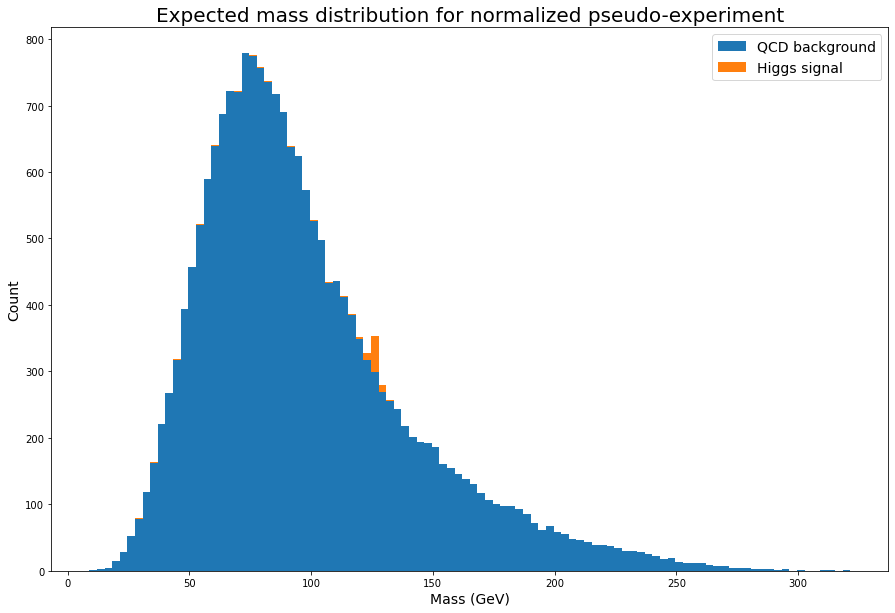

In [2]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
ax.hist(
    [qcd_data['mass'], higgs_data['mass']],
    weights=[qcd_data['weight'], higgs_data['weight']],
    label=["QCD background", "Higgs signal"],
    bins=100, 
    stacked=True
)
ax.set_xlabel("Mass (GeV)", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.set_title("Expected mass distribution for normalized pseudo-experiment", fontsize=20)
ax.legend(fontsize=14);

In the null hypothesis theory containing only QCD jets we expect to see 20,000 total events, while in the predicted theory containing the Higgs we expect to see 20,100 events. Assuming Poisson statistics, the probability of seeing 20,100 events anyway in the background theory is 0.238, corresponding to a significance of 0.711 sigma. This agrees well with the approximation $N_{Higgs}/\sqrt{N_{QCD}} = 0.707$. The origin of this approximation is that by the CLT, for large values of $\mu$, the Poisson distribution approaches a normal distribution with mean $\mu$ and standard deviation $\sqrt{\mu}$, in which case the significance of an observation $x$ is just $(x - \mu)/\sqrt{\mu}$. Since the Poisson distribution with $\mu = 20000$ is quite Gaussian, we would indeed expect the approximation to work well here. However, once we apply cuts to reduce $N_{QCD}$ this approximation will become rapidly less accurate, so we will not use it from here out.

In [3]:
# exact significance
prob = stats.poisson.sf(20100, mu=20000)
sigma = stats.norm.isf(prob)
print(f"{prob:.3} \t {sigma:.3} sigma")

0.238 	 0.711 sigma


In [4]:
# Gaussian approximation
print(f"{100/np.sqrt(20000):.3} sigma")

0.707 sigma


## Part 2

Since we will be trying to optimize the values for many different cuts on our data, it will be useful to first introduce some helper functions. In the following code, `cut` is assumed to be a function which takes a dataframe (either `qcd_data` or `higgs_data`) and an array of parameters and returns a boolean mask on the rows of the dataframe describing which events are to be included. `significance(cut, par)` is then the expected significance granted by using the filter `cut` with parameter array `par`. (Ignore the argument `incl` for now, we will address it later.) `loss(cut)` returns a function which takes a parameter array and returns the _negative_ expected significance; minimizing this function corresponds to finding the optimal parameters for `cut`. Once we have found the optimal parameters, `print_performance` then simply prints the expected significance and inclusion rates.

In [5]:
# expected significance in sigma granted by a given cut
def significance(cut, par, incl=0):
    higgs_count = np.sum(cut(higgs_data, par)) * higgs_weight
    if higgs_count < incl: return 0
    qcd_count = np.sum(cut(qcd_data, par)) * qcd_weight
    if qcd_count == 0: return 0 # avoid divide by 0
    return stats.norm.isf(stats.poisson.sf(qcd_count + higgs_count, mu=qcd_count))

# 
def loss(cut, incl=0):
    return lambda par: -significance(cut, par, incl)

def print_performance(cut, par):
    print(f"Significance: {significance(cut, par):.3} sigma")
    print("QCD Inclusion: {:.3}% \t Higgs Inclusion: {:.3}%\n".format(
        np.sum(cut(qcd_data, par)) / 1000,
        np.sum(cut(higgs_data, par)) / 1000
    ))

The first filter we will try is a straight-forward single feature cut on mass. We define a cut function `mass_cut` as described above which takes two parameters, the lower and upper bounds on mass.

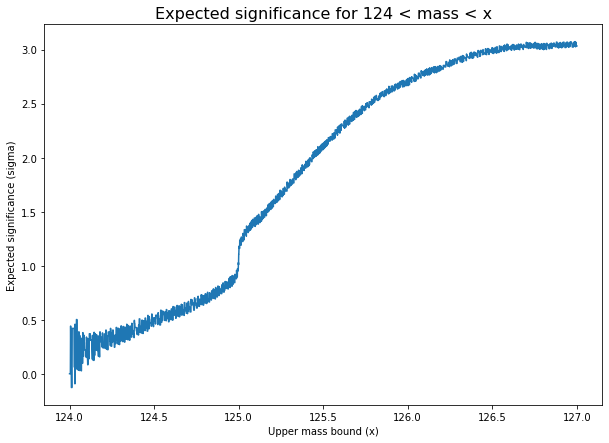

In [6]:
def mass_cut(data, par):
    [lower, upper] = par
    return (data['mass'] > lower) & (data['mass'] < upper)

xx = np.linspace(124, 127, 5000)
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.plot(xx, [significance(mass_cut, [124, x]) for x in xx])
ax.set_xlabel("Upper mass bound (x)")
ax.set_ylabel("Expected significance (sigma)")
ax.set_title("Expected significance for 124 < mass < x", fontsize=16);

Above, we have graphed the expected significance of this cut as a function of the upper bound, assuming a fixed lower bound of 124 GeV, and we can see that its derivative is extremely poorly behaved. This means that gradient-based optimization will not be effective. Instead, we use SciPy's differential evolution algorithm, which is stochastic and global.

In [7]:
res = optimize.differential_evolution(loss(mass_cut), [(0,200), (0,200)])
[mlower, mupper] = res.x
print(f"{mlower:.5} < mass < {mupper:.5}")
print_performance(mass_cut, res.x)

124.74 < mass < 126.56
Significance: 3.2 sigma
QCD Inclusion: 0.86% 	 Higgs Inclusion: 43.0%



The optimal cut provided by the minimizer is to take the mass range between 124.85 GeV and 126.72 GeV, which contains 44% of Higgs events and only 0.87% of QCD events, for an expected significance of 3.2 sigma.

## Section 3

Below, we have plotted stacked histograms of the expected distribution of each of the remaining features, both before and after applying the optimal mass cut found above. Because QCD events dominate the Higgs signal in the pre-cut data (20,000 to 100), we have amplified the Higgs signal by a factor of 20 in that case for clarity.

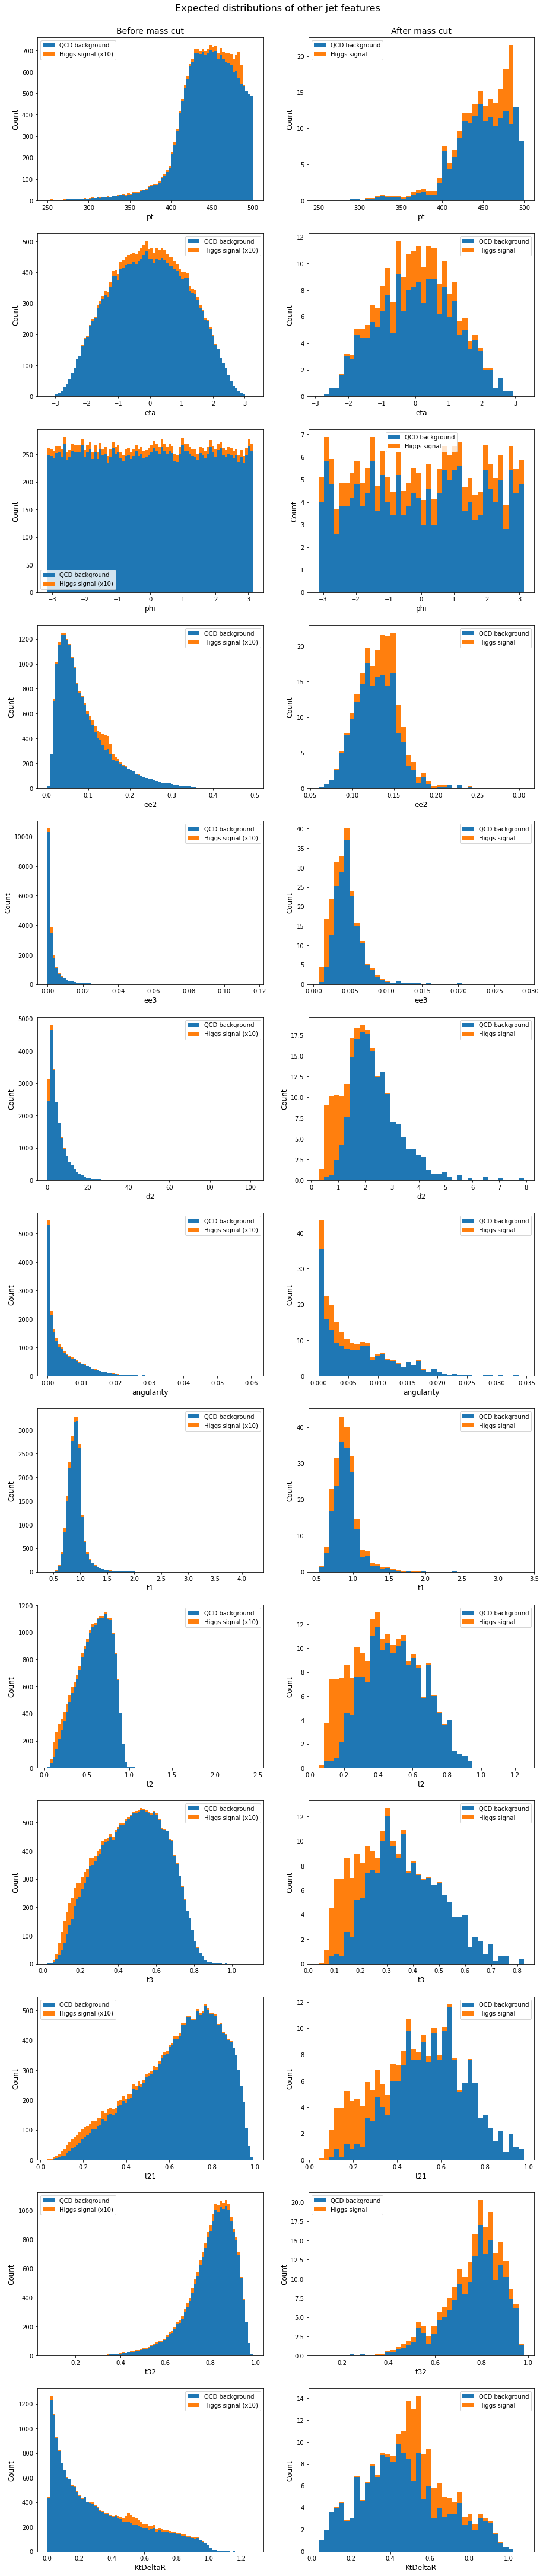

In [8]:
qcd_data_mcut = qcd_data[(qcd_data['mass'] > mlower) & (qcd_data['mass'] < mupper)]
higgs_data_mcut = higgs_data[(higgs_data['mass'] > mlower) & (higgs_data['mass'] < mupper)]

features = ['pt', 'eta', 'phi', 'ee2', 'ee3', 'd2', 'angularity', 't1', 't2', 't3', 't21', 't32', 'KtDeltaR']

fig, ax_grid = plt.subplots(len(features), 2, figsize=(15, 6*len(features)))

fig.suptitle("Expected distributions of other jet features", y=0.89, fontsize=16)
ax_grid[0,0].set_title("Before mass cut", fontsize=14)
ax_grid[0,1].set_title("After mass cut", fontsize=14)

for feature, axs in zip(features, ax_grid):
    axs[0].hist(
        [qcd_data[feature], higgs_data[feature]],
        weights=[qcd_data['weight'], 10 * higgs_data['weight']],
        label=["QCD background", "Higgs signal (x10)"],
        bins=80, 
        stacked=True
    )
    axs[1].hist(
        [qcd_data_mcut[feature], higgs_data_mcut[feature]],
        weights=[qcd_data_mcut['weight'], higgs_data_mcut['weight']],
        label=["QCD background", "Higgs signal"],
        bins=40, 
        stacked=True
    )
    for ax in axs:
        ax.legend()
        ax.set_xlabel(feature, fontsize=12)
        ax.set_ylabel("Count", fontsize=12)

On the raw data (left column), several features appear somewhat discriminative, but none appear remotely as good as mass.

## Section 4

After the mass cut (right column), the substructure features `d2`, `t2`, `t3` and `t21` all appear highly selective. In particular, Higgs jet seem to tend to sit below QCD jets on each of these axes. Thus, for each one, we try a two feature cut with a double ended bound on mass (as before) and an upper bound on the new feature. The ideal parameters in each case found by the optimizer are shown below.

In [9]:
cut_features = ['d2', 't2', 't3', 't21']

for feature in cut_features:
    def cut(data, par):
        [flim, mlower, mupper] = par
        return (data[feature] < flim) & (data['mass'] > mlower) & (data['mass'] < mupper)
    
    res = optimize.differential_evolution(loss(cut), [(0,4), (80,130), (110,160)])
    [flim, mlower, mupper] = res.x
    print(f"{feature} < {flim:.5}")
    print(f"{mlower:.5} < mass < {mupper:.5}")
    print_performance(cut, res.x)

d2 < 0.86763
124.14 < mass < 128.92
Significance: 11.5 sigma
QCD Inclusion: 0.007% 	 Higgs Inclusion: 28.7%

t2 < 0.19765
124.99 < mass < 127.15
Significance: 7.9 sigma
QCD Inclusion: 0.019% 	 Higgs Inclusion: 23.2%

t3 < 0.15207
124.99 < mass < 127.26
Significance: 8.23 sigma
QCD Inclusion: 0.017% 	 Higgs Inclusion: 24.0%

t21 < 0.25587
124.76 < mass < 126.62
Significance: 7.62 sigma
QCD Inclusion: 0.026% 	 Higgs Inclusion: 24.9%



We see that `d2` is by far the most useful discriminant. By selecting only jets with a mass between 124.1 and 128.9 GeV, and a `d2` value below 0.867, we can filter out all but 0.007% of QCD jets while keeping over a quarter of Higgs jets, for an expected significance of 11.5 sigma.

This seems too good to be true (even ignoring that this data is unrealistically clean), and it probably is. Since our training data contains 100,000 QCD jets, a QCD inclusion rate of 0.007% corresponds to only _7 jets_, which is too few to be confident our data is statistically representative. In other words, there is a risk that this filter is overfit to the training data. In an extreme case we can imagine a filter which selects a single Higgs jet and no QCD jets, which would have an infinite expected significance despite being practically useless. To prevent this type of overfitting we can set a minimum Higgs inclusion rate, which is the purpose of the optional `incl` argument in the `significance` and `loss` functions: any cut parameters which include less than `incl` percent of Higgs jets will be discarded during the search. Repeating the above with `incl` set to 50 gives the following results.

In [10]:
for feature in cut_features:
    def cut(data, par):
        [flim, mlower, mupper] = par
        return (data[feature] < flim) & (data['mass'] > mlower) & (data['mass'] < mupper)
    
    res = optimize.differential_evolution(loss(cut, 50), [(0,8), (50,125), (125,200)])
    [flim, mlower, mupper] = res.x
    print(f"{feature} < {flim:.5}")
    print(f"{mlower:.5} < mass < {mupper:.5}")
    print_performance(cut, res.x)

d2 < 1.237
124.02 < mass < 129.47
Significance: 8.03 sigma
QCD Inclusion: 0.13% 	 Higgs Inclusion: 50.1%

t2 < 0.28434
123.22 < mass < 129.6
Significance: 5.45 sigma
QCD Inclusion: 0.355% 	 Higgs Inclusion: 50.1%

t3 < 0.20251
123.5 < mass < 128.86
Significance: 6.8 sigma
QCD Inclusion: 0.205% 	 Higgs Inclusion: 50.1%

t21 < 0.34741
123.79 < mass < 129.04
Significance: 5.97 sigma
QCD Inclusion: 0.285% 	 Higgs Inclusion: 50.0%



This lowers the significance to 8 sigma, but with 126 QCD jets and more than half the Higgs jets included we can be more confident that this result will hold up when applied to real data. 

## Section 5

Below we have plotted 2D histograms of `mass` vs `d2` for both QCD and Higgs jets.

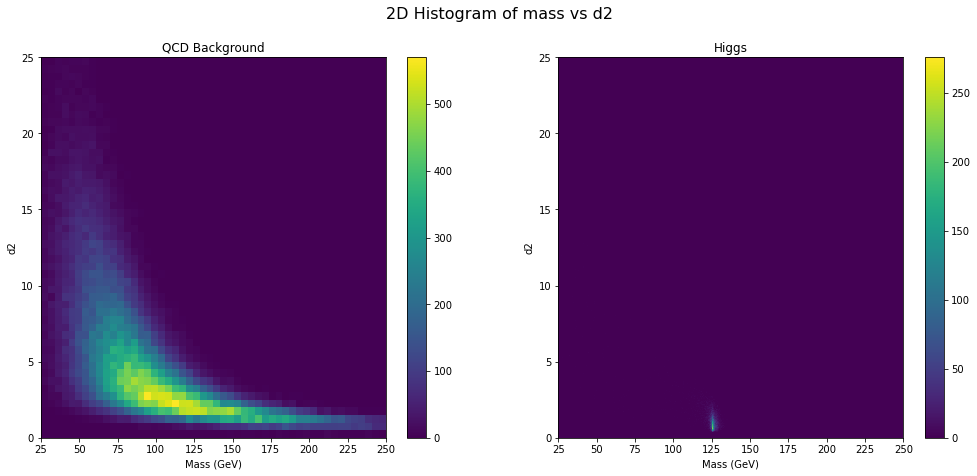

In [11]:
fig, axs = plt.subplots(1,2, figsize=(17,7))
_, _, _, img0 = axs[0].hist2d(qcd_data['mass'], qcd_data['d2'], bins=50, range=[[25,250],[0,25]])
_, _, _, img1 = axs[1].hist2d(higgs_data['mass'], higgs_data['d2'], bins=1000, range=[[25,250],[0,25]])
fig.suptitle("2D Histogram of mass vs d2", fontsize=16)
axs[0].set_title("QCD Background")
axs[1].set_title("Higgs")
for ax, img in zip(axs, [img0, img1]):
    fig.colorbar(img, ax=ax)
    ax.set_xlabel("Mass (GeV)")
    ax.set_ylabel("d2")


We can see immediately that these two features are not independent, but rather it appears, at least in the QCD data, that they are somewhat inversely correlated. The plots above both use the same axes to emphasize how much more tightly grouped the Higgs events are in feature space, but to make out any details of the Higgs distribution it is useful to zoom in somewhat.

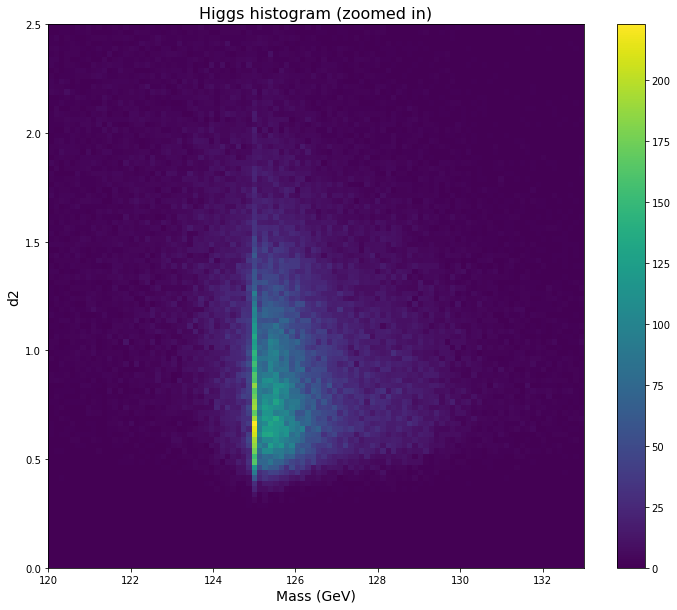

In [12]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
_, _, _, img = ax.hist2d(higgs_data['mass'], higgs_data['d2'], bins=100, range=[[120,133],[0,2.5]])
ax.set_title("Higgs histogram (zoomed in)", fontsize=16)
ax.set_xlabel("Mass (GeV)", fontsize=14)
ax.set_ylabel("d2", fontsize=14)
fig.colorbar(img, ax=ax);

From this we can see that the distribution has an apparently triangular shape, which motivates us to try selecting a region between two arbitrary lines in the `mass`-`d2` plane, giving us a triangular decision surface. To find the optimal such lines we follow the same procedure as before.

3.68 * d2 + 120.5 < mass < -8.71 * d2 + 137.4
Significance: 9.09 sigma
QCD Inclusion: 0.09% 	 Higgs Inclusion: 50.1%



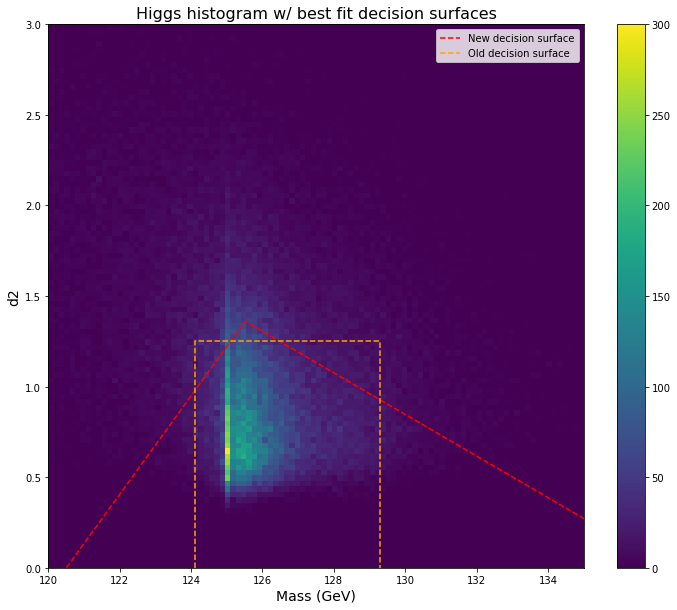

In [13]:
def triangle_cut(data, par):
    [m1,b1,m2,b2] = par
    mass = data['mass']
    d2 = data['d2']
    return (mass > m1 * d2 + b1) & (mass < m2 * d2 + b2)

res = optimize.differential_evolution(loss(triangle_cut, 50), [(0,30), (100,130), (-30,0), (120,150)])
[m1,b1,m2,b2] = res.x
print(f"{m1:.3} * d2 + {b1:.4} < mass < {m2:.3} * d2 + {b2:.4}")
print_performance(triangle_cut, res.x)

fig, ax = plt.subplots(1,1, figsize=(12,10))
_, _, _, img = ax.hist2d(higgs_data['mass'], higgs_data['d2'], bins=100, range=[[120,135],[0,3]])
[m1,b1,m2,b2] = res.x
int_mass =  (b1 - m1 / m2 * b2) / (1 - m1 / m2)
int_d2 = (int_mass - b2) / m2
ax.plot([b1, int_mass, b2], [0, int_d2, 0], color='red', linestyle='dashed', label="New decision surface")
ax.plot([124.1, 124.1, 129.3, 129.3], [0, 1.25, 1.25, 0], color='orange', linestyle='dashed', label="Old decision surface")
ax.set_title("Higgs histogram w/ best fit decision surfaces", fontsize=16)
ax.set_xlabel("Mass (GeV)", fontsize=14)
ax.set_ylabel("d2", fontsize=14)
ax.legend()
fig.colorbar(img, ax=ax);

We have plotted the decision surface found by the optimizer in red over top the 2D histogram. The independent 2-feature decision surface found in part 4 is also shown in orange for reference. The new filter has the same Higgs inclusion rate (50%) as the old one while managing a QCD inclusion rate that is apparently an order of magnitude lower, improving the expected significance from 8 sigma to 9 sigma.